# Feature Selection
The purpose of feature selection (or dimensionality reduction) methods is to (i) avoid the curse of dimensionality, (ii) reduce the amount of time and memory required by the data mining algorithms, (iii) help eliminating irrelevant features, (iv) reduce noise, and possibly (v) allow data to be more easily visualized.

There are several methods that can be used to perform feature selection that can be categorized in three main classes:
* Embedded approaches
* Filter approaches
* Wrapper approaches

In **embedded approaches**, feature selection naturally occurs as part of the data mining algorithm. Lasso and Ridge regression are examples of algorithms that embed feature selection. With **filter approaches**, the features are selected using a procedure that is independent from a specific data mining algorithm. For example, Principal Component Analysis (PCA) is an example of feature selection based on a filter approach. Another example is the selection of attributes based on a correlation measure. **Wrapper approaches** apply a data mining algorithm as a black box to find best subset of attributes. For example, we might apply greedy-search or a genetic algorithm to find the best set of features for a decision tree. Alternatively, we might apply a **brute-force** approach and try all possible feature subsets to find the best one for a specific mining algorithm. 

In this notebook we discuss some examples of filter and wrapper methods for feature selection. For this purpose, we will use the Boston Housing dataset. For further details on the function used we refer you to the Scikit-Learn page on [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html).


As usual, we begin by importing all the necessary libraries, we load the data, and set the random seed.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

%matplotlib inline

In [3]:
data = datasets.load_boston()

X = data["data"]
y = data["target"]

input_variables = data.feature_names
target_variable = 'MEDV'

seed = 1234

# let's create also a pandas data frame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = y
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Baseline Performance
Let's begin by computing a baseline for the dataset containing all the features. We will use this baseline performance to compare the predictive power of the feature subsets computed by all the methods discussed in this notebook.

The performance of basic linear regression using a ten-fold crossvalidation is 0.682.

In [4]:
kfolds = KFold(10,shuffle=True,random_state=seed)

model = linear_model.LinearRegression()
scores = cross_val_score(model, X, y, cv=kfolds) 

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.682 StdDev 0.125


## Reduced Variance Feature Selection
This feature selection algorithm computes the variance of all the variables and eliminates the variables with a variance below a certain threshold. The rationale is that, if the variance is very low, the values of the feature are very similar to each other so we may eliminate the variable. 


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Xs = scaler.fit_transform(data["data"])

feature_selection_variance_model = VarianceThreshold(threshold=0.05)
X_selected_features_variance = feature_selection_variance_model.fit_transform(Xs)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", data.feature_names[mask])
print("      Deleted Features = ", data.feature_names[~mask])

Reduced data set shape =  (506, 9)
     Selected features =  ['ZN' 'INDUS' 'CHAS' 'NOX' 'AGE' 'RAD' 'TAX' 'PTRATIO' 'B']
      Deleted Features =  ['CRIM' 'RM' 'DIS' 'LSTAT']


Text(0.5, 1.0, 'Variable CRIM')

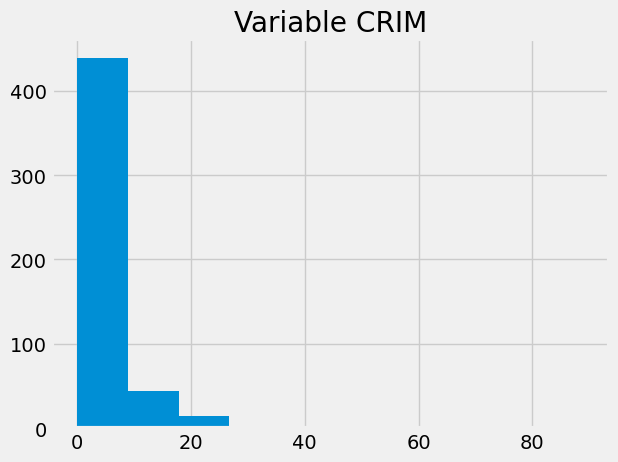

In [6]:
#plt.subplots(1,2,figsize=(16,6))

feat = 'CRIM'
plt.hist(df[feat],label=feat)
plt.title("Variable " + feat)




In [7]:
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, X[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Variance Model R2 Mean 0.395 StdDev 0.125


In the example below, the threshold is set as the variance of a Bernoulli distribution of a given probability (0.8 in this example). 

Reduced data set shape =  (506, 11)
     Selected features =  ['CRIM' 'ZN' 'INDUS' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']
      Deleted Features =  ['CHAS' 'NOX']


Text(0.5, 1.0, 'Variable CHAS')

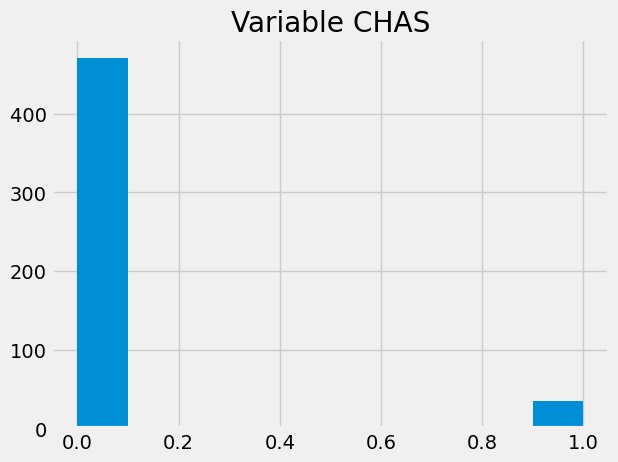

In [8]:
feature_selection_variance_model = VarianceThreshold(threshold=0.8*(1-0.8))
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)


mask2 = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", data.feature_names[mask2])
print("      Deleted Features = ", data.feature_names[~mask2])

#plt.subplots(1,2,figsize=(16,6))

feat = 'CHAS'
plt.hist(df[feat],label=feat)
plt.title("Variable " + feat)


In [9]:
chas_idx = df.columns.get_loc("CHAS")
mask[chas_idx] = False

print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", data.feature_names[mask])
print("      Deleted Features = ", data.feature_names[~mask])

    
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, X[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Reduced data set shape =  (506, 11)
     Selected features =  ['ZN' 'INDUS' 'NOX' 'AGE' 'RAD' 'TAX' 'PTRATIO' 'B']
      Deleted Features =  ['CRIM' 'CHAS' 'RM' 'DIS' 'LSTAT']
Variance Model R2 Mean 0.378 StdDev 0.127


## Univariate Feature Selection 
Univariate feature selection works by selecting the best features based on univariate statistical tests. In the example below, we apply *mutual_info_regression* that estimates mutual information for a continuous target variable.

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# apply the procedure to take the best k variables based on mutual_info_regression
feature_selection_univariate_model = SelectKBest(mutual_info_regression, k=4)

# fit the feature selection model and select the four variables
X_selected_features_univariate = feature_selection_univariate_model.fit_transform(X,y)

mask = feature_selection_univariate_model.get_support() #list of booleans
print("Reduced data set shape = ",X_selected_features_univariate.shape)
print("     Selected features = ",data.feature_names[mask])
print("      Deleted Features = ", data.feature_names[~mask])

Reduced data set shape =  (506, 4)
     Selected features =  ['INDUS' 'NOX' 'RM' 'LSTAT']
      Deleted Features =  ['CRIM' 'ZN' 'CHAS' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B']


In [11]:
univariate_model = linear_model.LinearRegression()
univariate_scores = cross_val_score(univariate_model, X[:,mask], y, cv=kfolds)
print("Univariate Model R2 Mean %.3f StdDev %.3f"%(univariate_scores.mean(),univariate_scores.std()))

Univariate Model R2 Mean 0.585 StdDev 0.147


This approach dramatically reduces the number of attributes but, at the same time, the reduced data set has a much lower performance. Interestingly, the feature that were eliminated are not very informative as well: in fact, if we compute the performance using the features that have been droppped we note that the performance is even lower. 

In [12]:
mask = np.invert(mask)
univariate_model = linear_model.LinearRegression()
univariate_scores = cross_val_score(univariate_model, X[:,mask], y, cv=kfolds)
print("Univariate Model R2 Mean %.3f StdDev %.3f"%(univariate_scores.mean(),univariate_scores.std()))

Univariate Model R2 Mean 0.435 StdDev 0.106


## Principal Component Analysis
Given a data set described by n features (dimensions), Principal component analysis (PCA) finds k≤n orthogonal vectors (also called dimensions or basis) that best capture the variance of the data. The orthogonal vector that captures the most variance is called the *first principal component*. The orthogonal direction that captures the second largest projected variance is called the second principal component, and so on.

We now apply principal component analysis. Since we need to decide how many component to select and for this purpose we apply PCA and plot the explained variance ratio and the cumulative explained variance. Note that to apply PCA we first need to normalize the data, which in this case we do by applying z-score normalization.

In [13]:
from sklearn.preprocessing import StandardScaler
full_pca_model = PCA()
X_std = StandardScaler().fit_transform(X)
full_fitted_model = full_pca_model.fit(X_std)

We can now plot the percentage of explained variance that every feature explains. In the plot below, we note that the first feature (the first principal components) explains 47.1% of the overall (100%) variance while the second feature (the second principal component) explains the secon

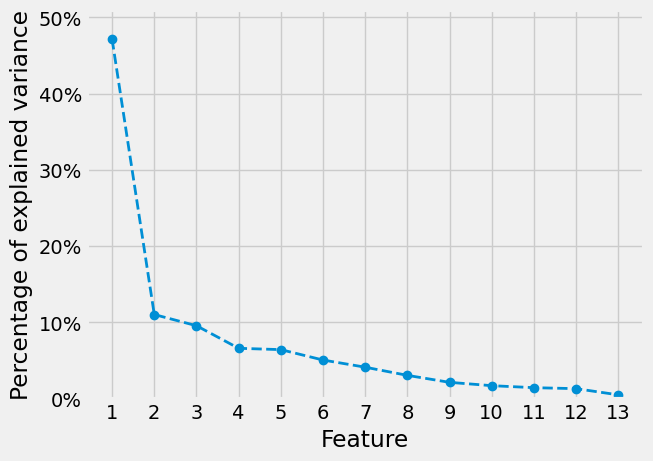

In [14]:
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,13,1),labels=np.arange(1,14,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,13,1),labels=np.arange(1,14,1));
plt.yticks(np.arange(0.0,0.51,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.51,.1)]);
plt.ylim([0.0,0.51]);

The plot above reports how much variance each component explains. When selecting the number of components we are typically interested in selecting enough dimensions to explain a target value of variance. For instance, we might be interested in selecting enough variables to explain 90% of the variance. Accordingly, we usually check the cumulative explained variance ratio reported below. As can be noted, the first 5 dimensions explain 80% of the variance while we need 7 dimensions to explain 90% of the variance.

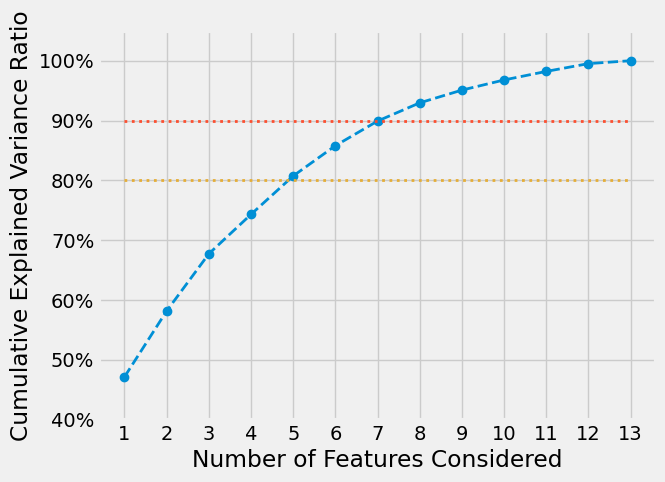

In [15]:
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,13,1),labels=np.arange(1,14,1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,12],[.9,.9],':');
plt.plot([0,12],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

Five components can actually explain 80% of the variance in the data so we apply PCA and select the first five components.

In [16]:
feature_selection_pca_model = PCA(n_components=5)
fitted_model = feature_selection_pca_model.fit(X_std)

X_selected_features_pca = fitted_model.transform(X_std)
print("    Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

    Explained Variance = 0.807
Reduced data set shape = (506, 5)


In [17]:
pca_model = linear_model.LinearRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, y, cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

PCA Model R2 Mean 0.648 StdDev 0.176


With using just the first five principal components as input variables, we reach the same performance as the one obtained with all the variables however The standard deviation is much higher than in the previous cases. The components are linear combinations of the original variables accordingly, when building a model using these new features we lose the connection with the original variables. For this purpose, it might interesting to check the weights that each component assigns to each original variable.

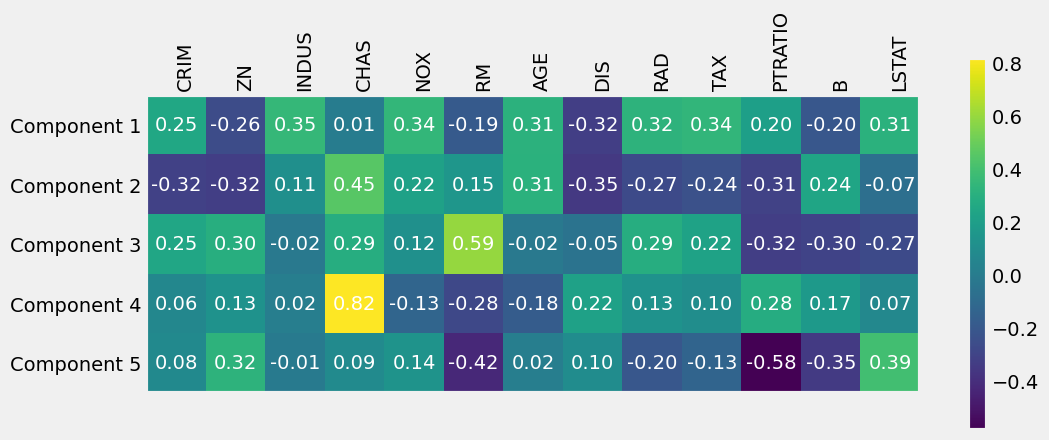

In [18]:
number_of_components = feature_selection_pca_model.components_.shape[0]
number_of_variables = feature_selection_pca_model.components_.shape[1]
component_ticks = np.arange(0,number_of_components,1)
component_labels = ['Component '+str(x+1) for x in component_ticks]

# plt.figure(figsize=(number_of_components*3,number_of_variables*3));
plt.matshow(feature_selection_pca_model.components_);
plt.yticks(component_ticks, labels=component_labels);
plt.colorbar();
plt.grid(False);
plt.xticks(range(len(input_variables)),input_variables,rotation=90,ha='left');
for (i, j), z in np.ndenumerate(feature_selection_pca_model.components_):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',color="white");
plt.show();# 

## Embedded Approaches
In Lasso, feature selection naturally occurs as part of the learning process. Thus, it is an example of an **embedded approaches** to feature selection. We now apply Lasso with a regularization coefficient (alpha) of 0.1 and evaluate its performance using 10-fold crossvalidation.

In [19]:
lasso_model = Lasso(alpha=0.01,max_iter=300,random_state=seed)
lasso_scores = cross_val_score(lasso_model, X, y, cv=kfolds)

print("Lasso R2 Mean %.3f StdDev %.3f"%(lasso_scores.mean(),lasso_scores.std()))

Lasso R2 Mean 0.681 StdDev 0.127


As can be noted the performance is slightly lower than the one obtained by the previous feature sets. The standard deviations is also higher than the one we had with all the features. Lasso performs feature selection by zeroing out the weights of less important variables. We can visualize the weights to understand 

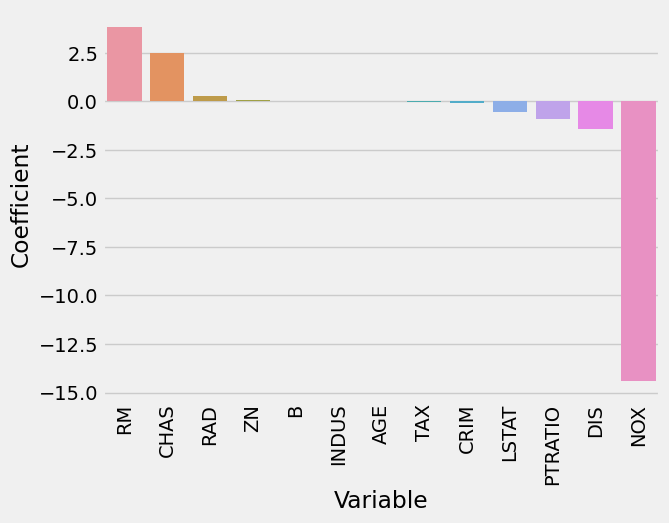

In [20]:
lasso_model.fit(X,y)
lr_coefficients = pd.DataFrame({'Variable':input_variables, 'Coefficient':lasso_model.coef_}).sort_values(by=['Coefficient'],ascending=False)
sns.barplot(x='Variable',y='Coefficient',data=lr_coefficients);
plt.xticks(rotation=90);

By modifying the regularization term alpha we can increase or decrease the amount of feature selection that Lasso performs.

## Recursive Feature Elimination
The previous approaches are all filter approaches in that they are not using the class information for the attribute selection. We start with a very simple one that starts from all the features and recursively consider smaller and smaller sets of features.

In [21]:
rfe = RFE(LinearRegression(), n_features_to_select=5,step=1)
rfe = rfe.fit(X, y)

X_selected_features_rfe = X[:,rfe.support_]

mask = rfe.get_support()
print("Reduced data set shape = ", X_selected_features_rfe.shape)
print("     Selected features = ", data.feature_names[mask])
print("      Deleted Features = ", data.feature_names[~mask])

Reduced data set shape =  (506, 5)
     Selected features =  ['CHAS' 'NOX' 'RM' 'DIS' 'PTRATIO']
      Deleted Features =  ['CRIM' 'ZN' 'INDUS' 'AGE' 'RAD' 'TAX' 'B' 'LSTAT']


In [22]:
rfe_model = LinearRegression()
rfe_scores = cross_val_score(rfe_model, X[:,mask], y, cv=kfolds)
print("RFE R2 Mean %.3f StdDev %.3f"%(rfe_scores.mean(),rfe_scores.std()))

RFE R2 Mean 0.574 StdDev 0.235


Note that the reported performance is much lower than in the previous cases and the standard deviation is much higher than in the previous cases.

## Random Forest
We now apply a random forest and use its scoring to select the attributes.

In [23]:
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(n_estimators=250, random_state=0)

Let's plot the feature importance.

Feature ranking:
 1. feature  5      RM (0.344)
 2. feature 12   LSTAT (0.340)
 3. feature 10 PTRATIO (0.056)
 4. feature  9     TAX (0.044)
 5. feature  4     NOX (0.041)
 6. feature  2   INDUS (0.035)
 7. feature  7     DIS (0.032)
 8. feature  0    CRIM (0.030)
 9. feature  8     RAD (0.022)
10. feature  6     AGE (0.020)
11. feature 11       B (0.019)
12. feature  3    CHAS (0.013)
13. feature  1      ZN (0.004)


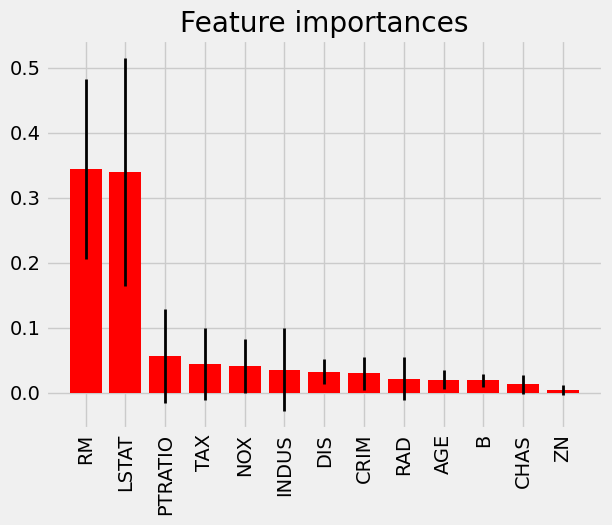

In [24]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], data.feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), data.feature_names[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [25]:
feature_selection_model = SelectFromModel(forest, prefit=True)

In [26]:
X_selected_features_forest = feature_selection_model.transform(X)
X_selected_features_forest.shape

(506, 2)

At this point, it would be interesting to compare the performance of our target regression algorithm on the reduced datasets. Note that, for wrapper feature selection the target algorithm and the algorithm used for selection usually coincide since wrapper approaches target selection for a specific algorithm and this should be the same later used for mining.

In [27]:
forest_model = linear_model.LinearRegression()
forest_scores = cross_val_score(forest_model, X_selected_features_forest, y, cv=kfolds)
print("RF Selected Features Model R2 Mean %.3f StdDev %.3f"%(forest_scores.mean(),forest_scores.std()))

RF Selected Features Model R2 Mean 0.590 StdDev 0.145


Also in this case the performance of the model using a subset of features is much lower than our baseling while the standard deviation is higher.

## Discussion
We applied several methods for feature selection some implementing a *filter* approach, one an embedded approach (Lasso), and some implementing a wrapper approach. As we noted, sometimes feature selection can improve the performance of a predictor by getting rid of less important variables or lead a similar performance as the one obtained using the original set of variables; in other cases, the smaller set of feature corresponds to a reduced performance. 

Performing feature selection is similar to tuning a hyperparameter of the algorithm accordingly we should apply the same procedures to guarantee a reliable evaluation of the performance. At the end, we should have compared the results we obtained to check whether the difference in performance was statistically significant. The quite high values of standard deviation associated with our crossvalidation suggest that probably none of the differences we recored will turn out to be significant. But this is left as an exercise to you.